In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sksurv
import sksurv.datasets
from sksurv.nonparametric import kaplan_meier_estimator

# Charger le dataset veterans_lung_cancer
X, y = sksurv.datasets.load_veterans_lung_cancer()

print("Shape du dataset X:", X.shape)
print("Colonnes disponibles:", X.columns.tolist())
print("Premières lignes de X:")
print(X.head())
print("\nInformations sur y (survie):")
print(y[:5])
print(f"Type de y: {type(y)}")
print(f"Structure de y: {y.dtype}")



Shape du dataset X: (137, 6)
Colonnes disponibles: ['Age_in_years', 'Celltype', 'Karnofsky_score', 'Months_from_Diagnosis', 'Prior_therapy', 'Treatment']
Premières lignes de X:
   Age_in_years  Celltype  Karnofsky_score  Months_from_Diagnosis  \
0          69.0  squamous             60.0                    7.0   
1          64.0  squamous             70.0                    5.0   
2          38.0  squamous             60.0                    3.0   
3          63.0  squamous             60.0                    9.0   
4          65.0  squamous             70.0                   11.0   

  Prior_therapy Treatment  
0            no  standard  
1           yes  standard  
2            no  standard  
3           yes  standard  
4           yes  standard  

Informations sur y (survie):
[( True,  72.) ( True, 411.) ( True, 228.) ( True, 126.) ( True, 118.)]
Type de y: <class 'numpy.ndarray'>
Structure de y: [('Status', '?'), ('Survival_in_days', '<f8')]


In [56]:
X['Celltype'].unique(), X['Treatment'].unique(), X['Prior_therapy'].unique()

(['squamous', 'smallcell', 'adeno', 'large']
 Categories (4, object): ['adeno', 'large', 'smallcell', 'squamous'],
 ['standard', 'test']
 Categories (2, object): ['standard', 'test'],
 ['no', 'yes']
 Categories (2, object): ['no', 'yes'])

In [57]:
# Ajuster l'estimateur de Kaplan-Meier
# Pour veterans_lung_cancer, les colonnes sont 'Status' et 'Survival_in_days'
time, survival_prob = kaplan_meier_estimator(y['Status'], y['Survival_in_days'])

print(f"Nombre de points temporels: {len(time)}")
print(f"Probabilité de survie initiale: {survival_prob[0]:.4f}")
print(f"Probabilité de survie finale: {survival_prob[-1]:.4f}")
print(f"Temps minimum: {time[0]:.2f} jours")
print(f"Temps maximum: {time[-1]:.2f} jours")
print(f"Nombre total de patients: {len(y)}")
print(f"Événements observés (décès): {np.sum(y['Status'])}")
print(f"Censures: {len(y) - np.sum(y['Status'])}")


Nombre de points temporels: 101
Probabilité de survie initiale: 0.9854
Probabilité de survie finale: 0.0000
Temps minimum: 1.00 jours
Temps maximum: 999.00 jours
Nombre total de patients: 137
Événements observés (décès): 128
Censures: 9


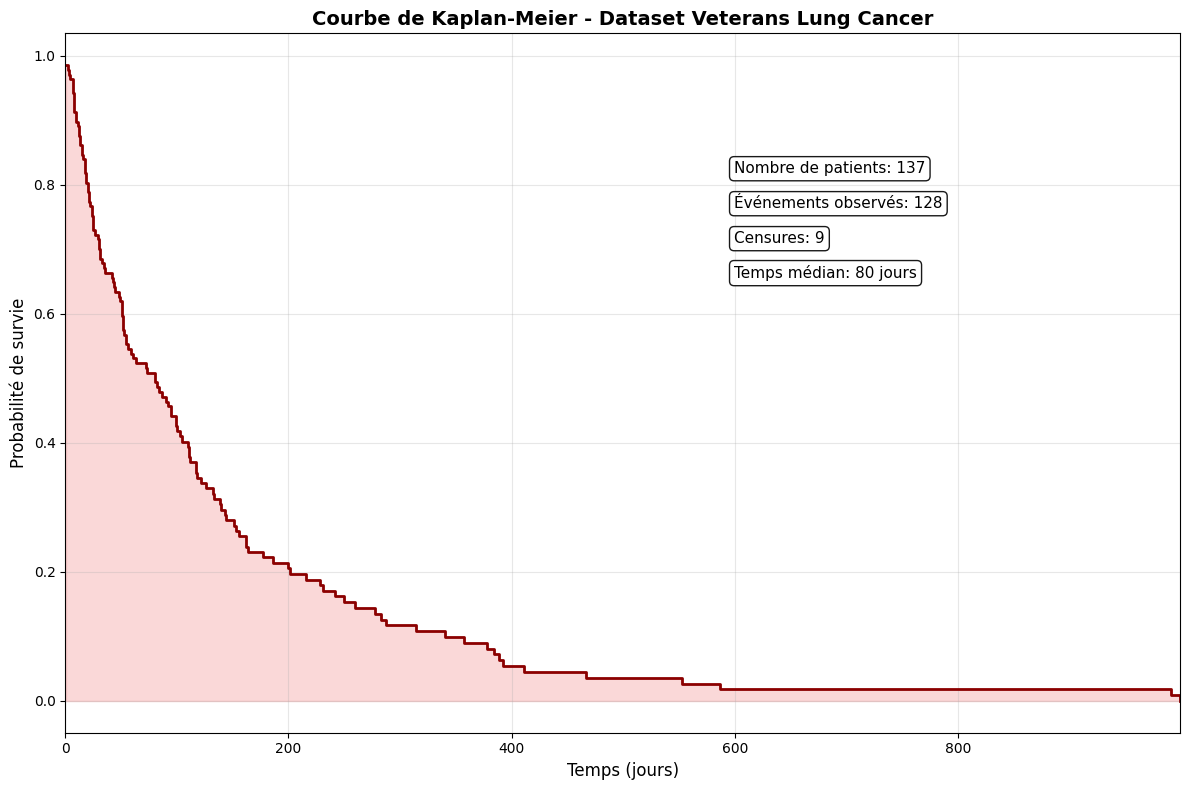

In [58]:
# Afficher la courbe de Kaplan-Meier
plt.figure(figsize=(12, 8))
plt.step(time, survival_prob, where="post", linewidth=2, color='darkred')
plt.fill_between(time, survival_prob, step="post", alpha=0.3, color='lightcoral')

plt.xlabel('Temps (jours)', fontsize=12)
plt.ylabel('Probabilité de survie', fontsize=12)
plt.title('Courbe de Kaplan-Meier - Dataset Veterans Lung Cancer', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim(0, time[-1])

# Ajouter des informations statistiques
plt.text(0.6, 0.8, f'Nombre de patients: {len(y)}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.75, f'Événements observés: {np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.7, f'Censures: {len(y) - np.sum(y["Status"])}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
plt.text(0.6, 0.65, f'Temps médian: {time[np.where(survival_prob <= 0.5)[0][0]]:.0f} jours', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

plt.tight_layout()
plt.show()


In [59]:
# Import de lifelines pour le modèle de Cox
from lifelines import CoxPHFitter
import pandas as pd

# Préparer les données pour lifelines
# Créer un DataFrame avec les variables de survie et les covariables
df_survival = pd.DataFrame({
    'duration': y['Survival_in_days'],  # Temps de survie
    'event': y['Status'],              # Événement (True = décès, False = censure)
    'Age_in_years': X['Age_in_years'],
    'Karnofsky_score': X['Karnofsky_score'],
    'Months_from_Diagnosis': X['Months_from_Diagnosis']
})

# Encoder les variables binaires
# Treatment: standard = 0, test = 1
df_survival['Treatment_encoded'] = (X['Treatment'] == 'test').astype(int)

# Prior_therapy: no = 0, yes = 1  
df_survival['Prior_therapy_encoded'] = (X['Prior_therapy'] == 'yes').astype(int)

# Encoder Celltype en variables dummy
celltype_dummies = pd.get_dummies(X['Celltype'], prefix='Celltype')
df_survival = pd.concat([df_survival, celltype_dummies], axis=1)

print("DataFrame préparé pour lifelines:")
print(df_survival.head())
print(f"\nShape du DataFrame: {df_survival.shape}")
print(f"Colonnes: {df_survival.columns.tolist()}")

DataFrame préparé pour lifelines:
   duration  event  Age_in_years  Karnofsky_score  Months_from_Diagnosis  \
0      72.0   True          69.0             60.0                    7.0   
1     411.0   True          64.0             70.0                    5.0   
2     228.0   True          38.0             60.0                    3.0   
3     126.0   True          63.0             60.0                    9.0   
4     118.0   True          65.0             70.0                   11.0   

   Treatment_encoded  Prior_therapy_encoded  Celltype_adeno  Celltype_large  \
0                  0                      0           False           False   
1                  0                      1           False           False   
2                  0                      0           False           False   
3                  0                      1           False           False   
4                  0                      1           False           False   

   Celltype_smallcell  Celltype_sq

In [60]:
df_survival.corr()

,duration,event,Age_in_years,Karnofsky_score,Months_from_Diagnosis,Treatment_encoded,Prior_therapy_encoded,Celltype_adeno,Celltype_large,Celltype_smallcell,Celltype_squamous
duration,1.000000,0.011926,-0.068327,0.381601,-0.046418,0.041531,0.093818,-0.181224,0.140159,-0.233343,0.292712
event,0.011926,1.000000,0.072258,-0.165087,0.050056,0.027528,-0.024123,0.057306,0.057306,0.009466,-0.114894
Age_in_years,-0.068327,0.072258,1.000000,-0.094985,-0.033422,0.076661,-0.099755,-0.042414,-0.098319,0.109667,0.008398
Karnofsky_score,0.381601,-0.165087,-0.094985,1.000000,-0.183712,-0.031964,-0.058514,-0.011370,0.159567,-0.184925,0.067120
Months_from_Diagnosis,-0.046418,0.050056,-0.033422,-0.183712,1.000000,0.011580,0.417624,-0.147322,-0.029312,0.033081,0.124922
Treatment_encoded,0.041531,0.027528,0.076661,-0.031964,0.011580,1.000000,-0.027421,0.168765,-0.051433,-0.178241,0.087961
Prior_therapy_encoded,0.093818,-0.024123,-0.099755,-0.058514,0.417624,-0.027421,1.000000,-0.116360,0.085429,-0.101442,0.139181
Celltype_adeno,-0.181224,0.057306,-0.042414,-0.011370,-0.147322,0.168765,-0.116360,1.000000,-0.245455,-0.363841,-0.290215
Celltype_large,0.140159,0.057306,-0.098319,0.159567,-0.029312,-0.051433,0.085429,-0.245455,1.000000,-0.363841,-0.290215
Celltype_smallcell,-0.233343,0.009466,0.109667,-0.184925,0.033081,-0.178241,-0.101442,-0.363841,-0.363841,1.000000,-0.430189


Modèle 1, "surraprenti", grosse pénalisation pour que le modèle de cox ne soit réduit qu'à sa composante temporelle

Modèle de Cox ajusté avec succès!
Log-likelihood: -502.9484
Concordance index: 0.7280
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Age_in_years           0.000470   1.000470  0.002471       -0.004374   
Karnofsky_score       -0.002070   0.997932  0.001309       -0.004636   
Months_from_Diagnosis  0.000564   1.000565  0.002474       -0.004285   
Treatment_encoded      0.003530   1.003537  0.051633       -0.097669   
Prior_therapy_encoded -0.010643   0.989414  0.056699       -0.121771   
Celltype_adeno         0.044329   1.045327  0.065712       -0.084464   
Celltype_large        -0.035079   0.965529  0.064350       -0.161203   
Celltype_smallcell     0.041119   1.041976  0.054554       -0.065804   
Celltype_squamous     -0.056900   0.944688  0.058992       -0.172522   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                  

<Figure size 1200x800 with 0 Axes>

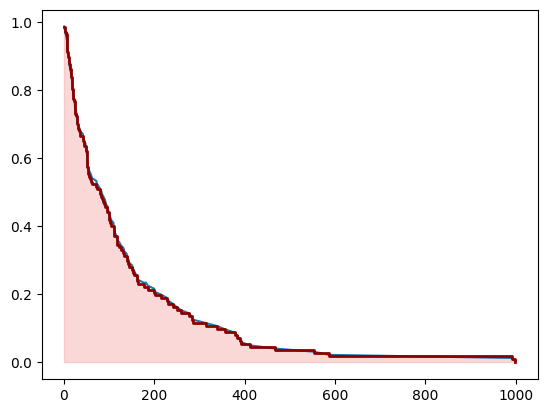

In [7]:
# Créer et ajuster le modèle de Cox
cph1 = CoxPHFitter(penalizer=10)  # Pénalisation L2 pour la régularisation

# Définir les covariables à inclure dans le modèle (sans Treatment)
covariates = [
    'Age_in_years',
    'Karnofsky_score', 
    'Months_from_Diagnosis',
    'Prior_therapy_encoded',
    'Celltype_adeno',
    'Celltype_large',
    'Celltype_smallcell',
    'Celltype_squamous'
]

# Ajuster le modèle de Cox
cph1.fit(df_survival, duration_col='duration', event_col='event')

print("Modèle de Cox ajusté avec succès!")
print(f"Log-likelihood: {cph1.log_likelihood_:.4f}")
print(f"Concordance index: {cph1.concordance_index_:.4f}")
print(cph1.summary)
plt.figure(figsize=(12, 8))
cph1.predict_survival_function(df_survival.iloc[0]).plot(legend=False)
plt.step(time, survival_prob, where="post", linewidth=2, color='darkred')
plt.fill_between(time, survival_prob, step="post", alpha=0.3, color='lightcoral')

Modèle 2,  petite pénalisation pour utiliser les covariables plus convenablement


Modèle de Cox ajusté avec succès!
Log-likelihood: -474.4389
Concordance index: 0.7359
                           coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                              
Age_in_years          -0.008660   0.991377  0.009294       -0.026877   
Karnofsky_score       -0.032759   0.967772  0.005502       -0.043543   
Months_from_Diagnosis  0.000104   1.000104  0.009129       -0.017788   
Treatment_encoded      0.293825   1.341549  0.207346       -0.112565   
Prior_therapy_encoded  0.071006   1.073588  0.232079       -0.383860   
Celltype_adeno         0.584170   1.793502  3.147230       -5.584288   
Celltype_large        -0.210038   0.810554  3.146532       -6.377127   
Celltype_smallcell     0.250047   1.284086  3.144765       -5.913580   
Celltype_squamous     -0.610469   0.543096  3.146178       -6.776864   

                       coef upper 95%  exp(coef) lower 95%  \
covariate                                                  

<Figure size 1200x800 with 0 Axes>

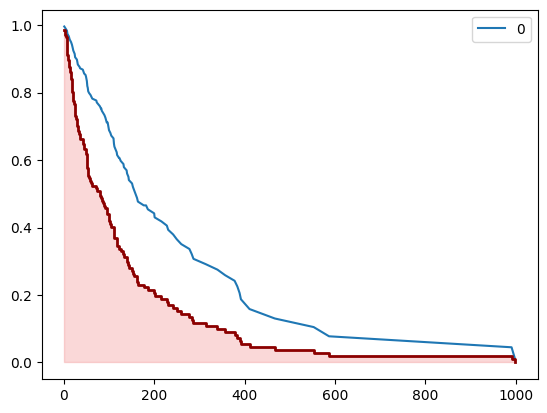

In [8]:
# Créer et ajuster le modèle de Cox
cph2 = CoxPHFitter(penalizer=0.001, l1_ratio=0)  # Pénalisation L2 pour la régularisation

# Définir les covariables à inclure dans le modèle (sans Treatment)
covariates = [
    'Age_in_years',
    'Karnofsky_score', 
    'Months_from_Diagnosis',
    'Prior_therapy_encoded',
    'Celltype_adeno',
    'Celltype_large',
    'Celltype_smallcell',
    'Celltype_squamous'
]

# Ajuster le modèle de Cox
cph2.fit(df_survival, duration_col='duration', event_col='event')

print("Modèle de Cox ajusté avec succès!")
print(f"Log-likelihood: {cph2.log_likelihood_:.4f}")
print(f"Concordance index: {cph2.concordance_index_:.4f}")
print(cph2.summary)
plt.figure(figsize=(12, 8))
cph2.predict_survival_function(df_survival.iloc[0]).plot()
plt.step(time, survival_prob, where="post", linewidth=2, color='darkred')
plt.fill_between(time, survival_prob, step="post", alpha=0.3, color='lightcoral')

Visualisation de l'influence des paramètres de covariables en fct de la pénalisation

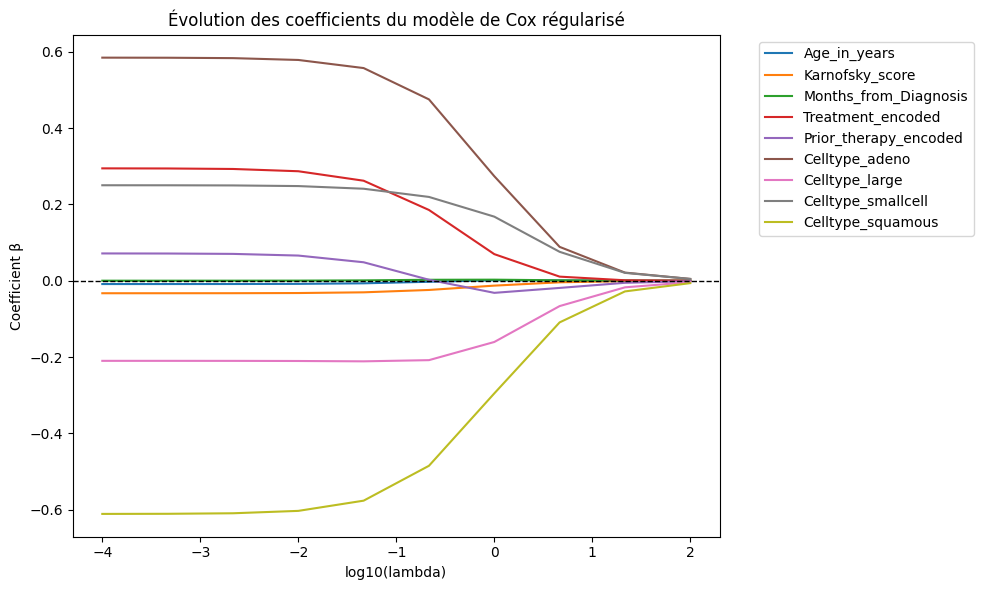

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Liste des valeurs de pénalisation à tester (échelle logarithmique)
penalties = np.logspace(-4, 2, 10)  # de 1e-4 à 1e+2
coef_paths = []

# Ajuster un modèle pour chaque valeur de penalizer
for lam in penalties:
    cph = CoxPHFitter(penalizer=lam)
    cph.fit(df_survival, duration_col='duration', event_col='event')
    coef_paths.append(cph.params_.values)

# Créer un DataFrame pour les coefficients
coef_paths = pd.DataFrame(coef_paths, columns=cph.params_.index, index=penalties)

# Tracer les trajectoires
plt.figure(figsize=(10, 6))
for col in coef_paths.columns:
    plt.plot(np.log10(coef_paths.index), coef_paths[col], label=col)

plt.xlabel('log10(lambda)')
plt.ylabel('Coefficient β')
plt.title('Évolution des coefficients du modèle de Cox régularisé')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Visualisation de la valeur du C-index et de la log-likelihood en fct de lambda

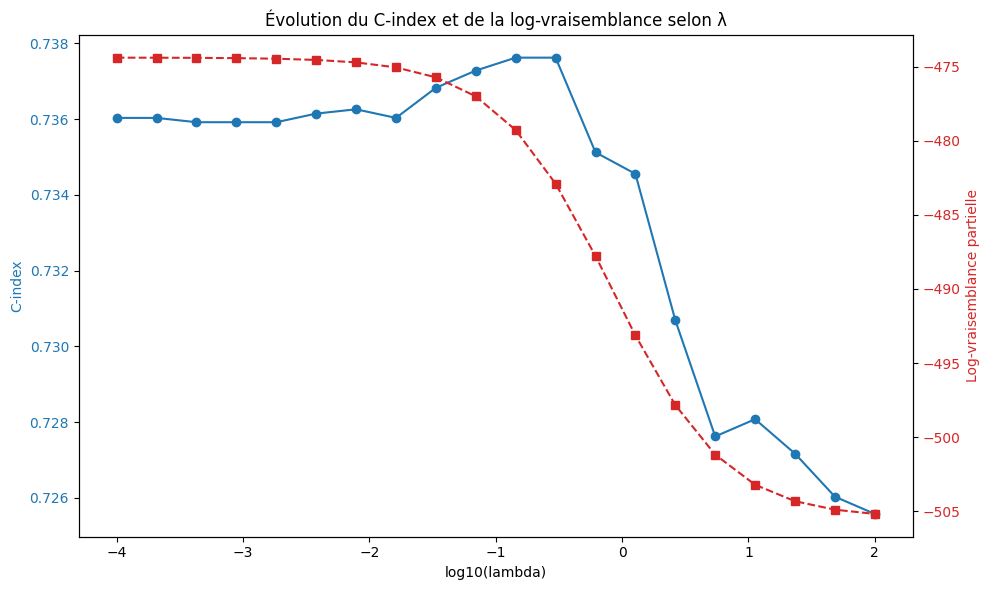

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Grille de valeurs de pénalisation à tester
penalties = np.logspace(-4, 2, 20)

# Stocker les résultats
cindex_values = []
loglik_values = []

# Boucle sur chaque lambda
for lam in penalties:
    cph = CoxPHFitter(penalizer=lam)
    cph.fit(df_survival, duration_col='duration', event_col='event')
    
    # Calcul du C-index
    risk_scores = cph.predict_partial_hazard(df_survival)
    cindex = concordance_index(df_survival['duration'], -risk_scores, df_survival['event'])
    cindex_values.append(cindex)
    
    # Log-vraisemblance du modèle
    loglik_values.append(cph.log_likelihood_)

# Créer un DataFrame pour faciliter le tracé
results = pd.DataFrame({
    'lambda': penalties,
    'C-index': cindex_values,
    'Log-likelihood': loglik_values
})

# --------- Tracé combiné ---------
fig, ax1 = plt.subplots(figsize=(10,6))

# Axe 1 : C-index
ax1.plot(np.log10(results['lambda']), results['C-index'],
         color='tab:blue', marker='o', label='C-index')
ax1.set_xlabel('log10(lambda)')
ax1.set_ylabel('C-index', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Axe 2 : Log-likelihood
ax2 = ax1.twinx()
ax2.plot(np.log10(results['lambda']), results['Log-likelihood'],
         color='tab:red', linestyle='--', marker='s', label='Log-likelihood')
ax2.set_ylabel('Log-vraisemblance partielle', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Mise en forme
plt.title('Évolution du C-index et de la log-vraisemblance selon λ')
fig.tight_layout()
plt.show()
